In [1]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.3/152.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 6.2 MB/s eta 0:00:00


In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.evaluation.single_table import evaluate_quality
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [3]:
# Load the Bike Sharing dataset
bike_sharing_data = pd.read_csv("/content/day.csv")
bike_sharing_data

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [4]:
# Drop irrelevant columns
bike_sharing_data.drop(columns=['instant', 'dteday', 'casual', 'registered'], inplace=True)
bike_sharing_data

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,2114
727,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,3095
728,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,1341
729,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,1796


In [5]:
# Split into train and test sets
train_data, test_data = train_test_split(bike_sharing_data, test_size=0.2, random_state=42)

# Separate features and target
X_train = train_data.drop(columns=['cnt'])
y_train = train_data['cnt']
X_test = test_data.drop(columns=['cnt'])
y_test = test_data['cnt']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Create metadata from Bike Sharing dataset
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=bike_sharing_data)

# Instantiate Gaussian Copula synthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)

# Fit the synthesizer on the training data
synthesizer.fit(train_data)

# Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=len(train_data))

/usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:120: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [7]:
synthetic_data

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,2,0,4,0,1,0.319741,0.380362,0.576373,0.264678,3152
1,2,0,4,0,4,1,1,0.252883,0.274642,0.685218,0.210921,4150
2,2,0,1,0,0,1,1,0.126272,0.129263,0.435586,0.123349,977
3,4,1,7,0,0,1,1,0.543583,0.518136,0.698321,0.087212,4548
4,3,0,4,0,6,1,1,0.525316,0.555391,0.733998,0.123622,6491
...,...,...,...,...,...,...,...,...,...,...,...,...
579,1,1,4,0,5,0,2,0.550879,0.509754,0.879075,0.206053,1139
580,2,0,6,0,4,1,1,0.152341,0.129217,0.552546,0.094967,1747
581,1,1,3,0,1,1,1,0.257079,0.282141,0.613208,0.148991,6010
582,1,1,3,0,6,0,1,0.621157,0.561802,0.533698,0.164715,5183


In [8]:
# Run a diagnostic to ensure that the data is valid
from sdv.evaluation.single_table import run_diagnostic

diagnostic=run_diagnostic(train_data, synthetic_data, metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 12/12 [00:00<00:00, 623.63it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 133.73it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



**From above we can see that the score is 100%, indicating that the data is fully valid.**

In [11]:
# Evaluate synthetic data quality
quality_report = evaluate_quality(train_data, synthetic_data, metadata)
quality_report.get_details('Column Shapes')

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 392.24it/s]|
Column Shapes Score: 95.32%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 86.10it/s]|
Column Pair Trends Score: 87.65%

Overall Score (Average): 91.48%



,Column,Metric,Score
0,season,TVComplement,0.969178
1,yr,TVComplement,0.972603
2,mnth,KSComplement,0.864726
3,holiday,TVComplement,0.996575
4,weekday,TVComplement,0.958904
5,workingday,TVComplement,0.957192
6,weathersit,TVComplement,0.974315
7,temp,KSComplement,0.964041
8,atemp,KSComplement,0.938356
9,hum,KSComplement,0.934932


**According to the overall score, the synthetic data is about 91.48% similar to the real data in terms of statistical similarity.**

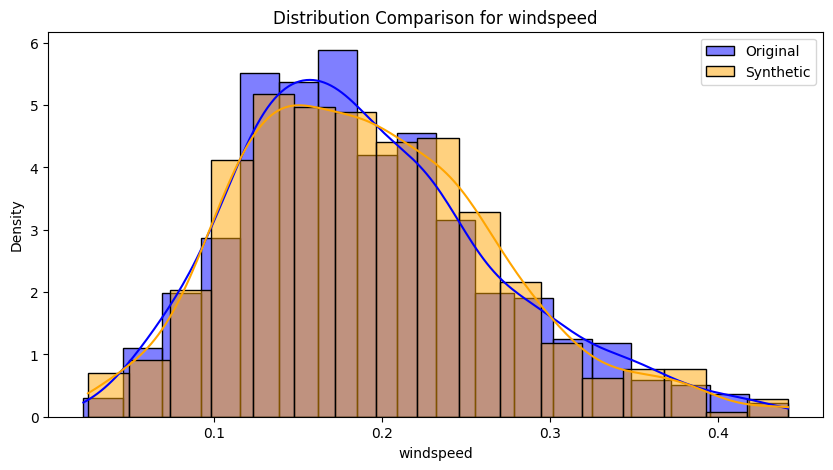

In [19]:
# Plot distribution comparison for a sample feature
for col in X_train.columns[10:11]:
    plt.figure(figsize=(10, 5))
    sns.histplot(X_train[col], color='blue', label='Original', kde=True, stat='density')
    sns.histplot(synthetic_data[col], color='orange', label='Synthetic', kde=True, stat='density')
    plt.title(f'Distribution Comparison for {col}')
    plt.legend()
    plt.show()

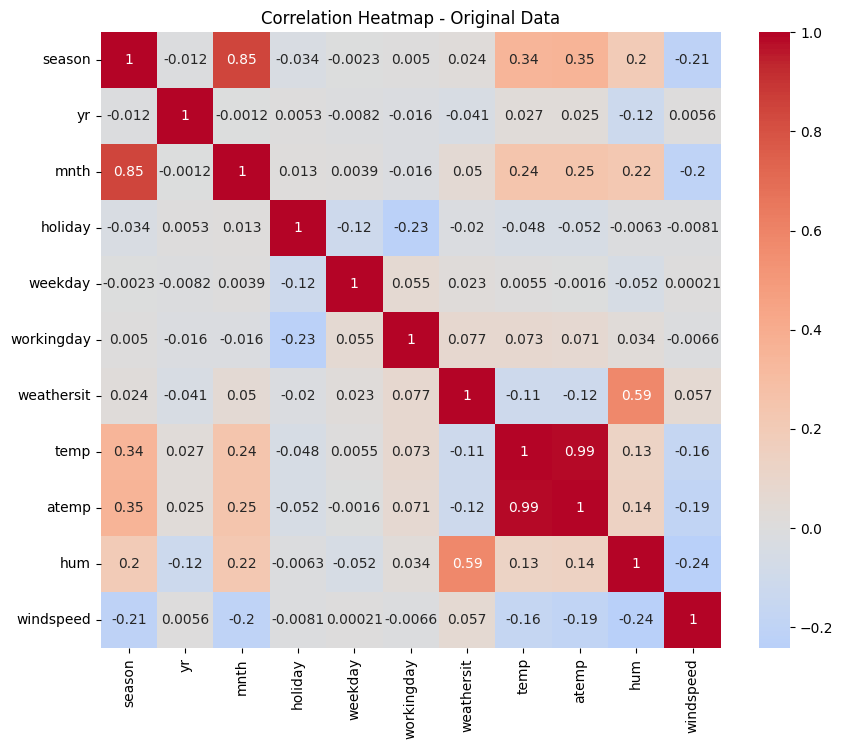

In [20]:
# Compute correlation matrices
corr_original = X_train.corr()
corr_synthetic = synthetic_data.corr()

# Plot heatmap for original data
plt.figure(figsize=(10, 8))
sns.heatmap(corr_original, annot=True, cmap="coolwarm", center=0)
plt.title('Correlation Heatmap - Original Data')
plt.show()

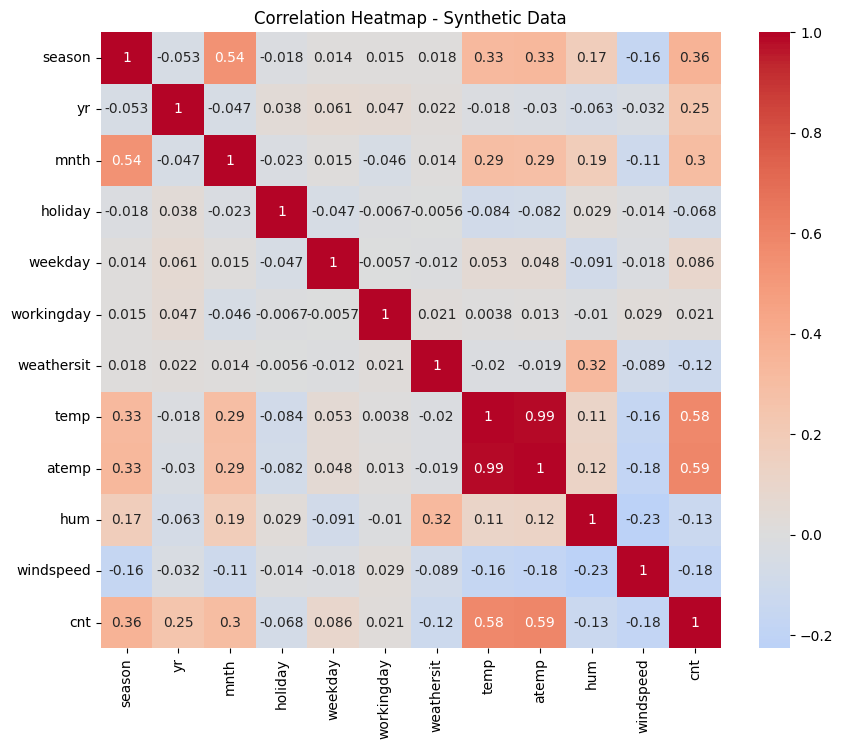

In [21]:
# Plot heatmap for synthetic data
plt.figure(figsize=(10, 8))
sns.heatmap(corr_synthetic, annot=True, cmap="coolwarm", center=0)
plt.title('Correlation Heatmap - Synthetic Data')
plt.show()

In [27]:
# Utility function for evaluating regression models
def evaluate_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

models = {
    'Linear Regression': LinearRegression(),
    'SVR': SVR(kernel='rbf', C=100)
}

print("Real Data Results:")
for name, model in models.items():
    mse, mae, r2 = evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, model)
    print(f"{name}: MSE = {mse:.4f}, MAE = {mae:.4f}, R2 = {r2:.4f}")

# Preprocess synthetic data
X_synth = synthetic_data.drop(columns=['cnt'])
y_synth = synthetic_data['cnt']
X_synth_scaled = scaler.fit_transform(X_synth)

print("\nSynthetic Data Results:")
for name, model in models.items():
    mse, mae, r2 = evaluate_model(X_synth_scaled, y_synth, X_test_scaled, y_test, model)
    print(f"{name}: MSE = {mse:.4f}, MAE = {mae:.4f}, R2 = {r2:.4f}")


Real Data Results:
Linear Regression: MSE = 691035.0082, MAE = 617.3931, R2 = 0.8277
SVR: MSE = 758295.0741, MAE = 632.5248, R2 = 0.8109

Synthetic Data Results:
Linear Regression: MSE = 1077541.9632, MAE = 804.6378, R2 = 0.7313
SVR: MSE = 1835414.7475, MAE = 1137.6762, R2 = 0.5423
